## Seminar Data Mining

### Student: Juan Manuel González Huesca
### Supervisor:  prof. dr. Mykola Pechenizkiy

###### ------------------------------------------------------------------------------------------------------------------------

### 1. Import of python libraries

In [44]:
import pandas as pd
import dateutil
import nltk
import re
from nltk.chunk import conlltags2tree, tree2conlltags
from nltk import word_tokenize, pos_tag, ne_chunk
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set()
import itertools

In [15]:
df = pd.read_csv('emails.csv')
print("Number of emails: ",df.shape[0])

Number of emails:  517401


### 2. Function to extract email body from dataframe

In [16]:
#Get email section from dataframe
email=df.iloc[3][1]

#Remove metadata
email_body=email.split(r'X-FileName:',1)[1]

#Get just email body and remove empty lines
email_body_cleaned = email_body.replace('\n\n','\n')
email_body_compact = email_body_cleaned.split("\n",1)[1]

In [17]:
print("Number of words in email test: ",len(email_body_compact.split()))

Number of words in email test:  34


### 3. Entity extraction with NTLK library

In [20]:
dfinal = pd.DataFrame(columns=['ID','Date','Email-body','Entity','Sender','Recipient'])
for num in range(50000):
    #dfinal = dfinal.append({'ID': num}, ignore_index=True)
    
    email=df.iloc[num][1]
    email_body=email.split(r'X-FileName:',1)[1]
    email_body_cleaned = email_body.replace('\n\n','\n')
    email_body_compact = email_body_cleaned.split("\n",1)[1]

    tokens = nltk.word_tokenize(email_body_compact)
    tagged = nltk.pos_tag(tokens)
    entities = nltk.chunk.ne_chunk(tagged)
    iob_tagged = tree2conlltags(entities)

    listaFinal=[]
    for x in range(len(iob_tagged)):
        listaFinal.append([iob_tagged[x][2],iob_tagged[x][0]])

    listaFinal2=[]
    for i in range(len(listaFinal)):
        if "-" in listaFinal[i][0]:
            listaFinal2.append([listaFinal[i][0].split('-')[1],listaFinal[i][1]])
        else:
            listaFinal2.append([listaFinal[i][0],listaFinal[i][1]])

    tf=[[key, [n for _, n in grp]] for key, grp in itertools.groupby(listaFinal2, key=lambda x: x[0])]

    final_value=""
    for y in range(len(tf)):
        if "ORGANIZATION" in tf[y][0]:
            final_value=' '.join(tf[y][1])
    
    date = dateutil.parser.parse(' '.join(df.iloc[num][1].split('Date: ',1)[1].split('\n', 1)[0].split()[1:5]))
    sender = df.iloc[num][1].split('From: ',1)[1].split('\n', 1)[0]
    recipient = df.iloc[num][1].split('To: ',1)[1].split('\n', 1)[0]

    dfinal = dfinal.append({'ID': num+1,'Date': date,'Email-body': email_body_compact,
                            'Entity': final_value,'Sender': sender,'Recipient': recipient}, ignore_index=True)

In [22]:
print("Number of emails analyzed: ",len(dfinal))

Number of emails analyzed:  50000


In [25]:
list_of_entities = dfinal["Entity"].tolist()
unique_entities = set(list_of_entities)
print("Number of unique entities: ",len(unique_entities))

Number of unique entities:  5818


### 4. CSV creation with columns "ID", "Date" and "Entity"

In [26]:
#Create dataframe with just two columns, timestamp and entity
dfinal2 = dfinal[['ID','Date', 'Entity']]

In [27]:
dfinal2.to_csv('matrix-entities-timestamp.csv',encoding='utf-8', index=False)

### 5. External processing

###### 5.1 The "Entity" column was cleaned from special characters and string truncated to 40 chars

##### 5.2 Using Microsoft SQL Server SMS, the frequency per month of the most relevant entities was extracted to create the heatmap table, the input for the seaborn.heatmap python library.

### 6. Heatmap creation

In [28]:
heatmap = pd.read_csv('heatmapfinal.csv')

In [29]:
finalheatmap = heatmap.pivot("Entity", "Date", "Frequency")

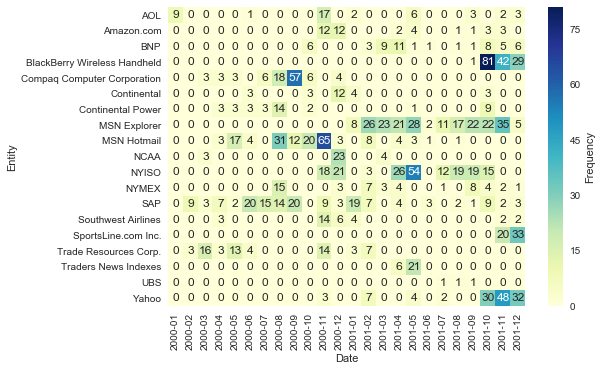

In [42]:
sns.heatmap(finalheatmap,annot=True,  cmap="YlGnBu", cbar_kws={'label': 'Frequency'})
plt.show()

### Citation:
Bird, Steven, Edward Loper and Ewan Klein (2009), Natural Language Processing with Python. O’Reilly Media Inc.